In [1]:
import os
import pandas as pd
import numpy as np
import pgeocode
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from typing import defaultdict
from pandarallel import pandarallel

In [2]:
data_path = '..\\data\\'

In [3]:
clients_data = pd.read_csv(data_path + 'test_data_npo\\npo_clnts.csv')

In [4]:
def columns_report(data: pd.DataFrame) -> None:

    print('Rows:', data.shape[0], end='\n'*2)

    stats = defaultdict(list)
    for col in data.columns:
        stats['Column'].append(col)
        stats['Unique'].append(data[col].nunique())
        stats['Duplicates'].append(data[col].duplicated().sum())
        stats['Missing'].append(data[col].isna().sum())
        stats['Missing%'].append(data[col].isna().mean() * 100)
        stats['HitRate%'].append((1 - data[col].isna().mean()) * 100)
    stats = pd.DataFrame(stats)

    print(stats.to_string(index=False))

In [5]:
clients_cleaned = clients_data.copy()

In [6]:
clients_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102901 entries, 0 to 102900
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clnt_id     102901 non-null  object 
 1   gndr        102897 non-null  float64
 2   slctn_nmbr  102901 non-null  int64  
 3   age         102892 non-null  float64
 4   brth_yr     102892 non-null  float64
 5   pstl_code   97917 non-null   object 
 6   city        102901 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 5.5+ MB


In [7]:
columns_report(clients_cleaned)

Rows: 102901

    Column  Unique  Duplicates  Missing  Missing%   HitRate%
   clnt_id  102887          14        0  0.000000 100.000000
      gndr       2      102898        4  0.003887  99.996113
slctn_nmbr       4      102897        0  0.000000 100.000000
       age     114      102786        9  0.008746  99.991254
   brth_yr     113      102787        9  0.008746  99.991254
 pstl_code   14519       88381     4984  4.843490  95.156510
      city       2      102899        0  0.000000 100.000000


In [8]:
postal_code_pattern = r'^\d{6}$'
clients_cleaned['pstl_code'] = clients_cleaned.pstl_code.str.replace('.0', '')
clients_cleaned.loc[~(clients_cleaned.pstl_code.str.match(postal_code_pattern, na=False)), 'pstl_code'] = np.nan
clients_cleaned['pstl_code'] = clients_cleaned.pstl_code.astype(float).fillna(-1).astype(int).astype(str)\
    .replace('-1', '_MISSING_')
pcode_mode = clients_cleaned.loc[clients_cleaned.pstl_code != '_MISSING_', 'pstl_code'].mode()[0]
clients_cleaned['pstl_code']= clients_cleaned.pstl_code.replace('_MISSING_', pcode_mode)

In [9]:
postal_decoder = pgeocode.Nominatim('ru')

def get_geosub_from_postalcode(postal_code: str, decoder=postal_decoder) -> str:

    geo = decoder.query_postal_code(postal_code).state_name

    return geo

In [10]:
print(os.cpu_count())

16


In [11]:
# получение геопозиции по почтовому индексу
pandarallel.initialize(progress_bar=True, nb_workers=12)
clients_cleaned['geo'] = clients_cleaned.pstl_code.parallel_apply(get_geosub_from_postalcode)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [12]:
# заполнение недостающих геопозиций по индексам с такой же частью, отвечающей за код города
no_geo_pstl_codes = clients_cleaned.loc[clients_cleaned.geo.isna(), 'pstl_code'].unique().tolist()

for pstl_code in no_geo_pstl_codes:
    no_geo_city_code = pstl_code[:3]
    try:
        twin_geo = clients_cleaned.loc[(clients_cleaned.pstl_code.str[:3] == no_geo_city_code) &\
            (clients_cleaned.geo.notna()), 'geo'].unique()[0]
    except IndexError:
        twin_geo = None
    clients_cleaned.loc[clients_cleaned.pstl_code == pstl_code, 'geo'] = twin_geo

In [13]:
clients_cleaned.dropna(subset=['gndr', 'age', 'brth_yr', 'geo'], inplace=True)
clients_cleaned.drop_duplicates(subset=['clnt_id'], keep='first', inplace=True)
clients_cleaned.reset_index(drop=True, inplace=True)

In [14]:
clients_cleaned['gndr'] = clients_cleaned.gndr.astype(int)
clients_cleaned['age'] = clients_cleaned.age.astype(int)
clients_cleaned['brth_yr'] = clients_cleaned.brth_yr.astype(int)

In [15]:
columns_report(clients_cleaned)

Rows: 102510

    Column  Unique  Duplicates  Missing  Missing%  HitRate%
   clnt_id  102510           0        0       0.0     100.0
      gndr       2      102508        0       0.0     100.0
slctn_nmbr       4      102506        0       0.0     100.0
       age     113      102397        0       0.0     100.0
   brth_yr     112      102398        0       0.0     100.0
 pstl_code   10377       92133        0       0.0     100.0
      city       2      102508        0       0.0     100.0
       geo      78      102432        0       0.0     100.0


In [16]:
clients_cleaned.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

,gndr,slctn_nmbr,age,brth_yr,city
count,102510.000000,102510.000000,102510.000000,102510.000000,102510.000000
mean,0.437196,1.449751,55.652336,1967.013647,0.247556
std,0.496042,0.841487,23.181744,23.190421,0.431595
min,0.000000,0.000000,-976.000000,1.000000,0.000000
1%,0.000000,0.000000,30.000000,1932.000000,0.000000
10%,0.000000,0.000000,38.000000,1951.000000,0.000000
25%,0.000000,1.000000,46.000000,1958.000000,0.000000
50%,0.000000,2.000000,56.000000,1966.000000,0.000000
75%,1.000000,2.000000,65.000000,1977.000000,0.000000
90%,1.000000,2.000000,71.000000,1984.000000,1.000000


In [17]:
clients_cleaned = clients_cleaned.loc[(clients_cleaned.age >= 18) & (clients_cleaned.age <= 90)].reset_index(drop=True)

In [18]:
clients_cleaned.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

,gndr,slctn_nmbr,age,brth_yr,city
count,101404.000000,101404.000000,101404.000000,101404.000000,101404.000000
mean,0.434924,1.453897,55.278086,1967.391385,0.243432
std,0.495749,0.844190,12.434165,12.431459,0.429156
min,0.000000,0.000000,18.000000,1932.000000,0.000000
1%,0.000000,0.000000,30.000000,1938.000000,0.000000
5%,0.000000,0.000000,35.000000,1948.000000,0.000000
10%,0.000000,0.000000,38.000000,1952.000000,0.000000
25%,0.000000,1.000000,46.000000,1958.000000,0.000000
50%,0.000000,2.000000,56.000000,1967.000000,0.000000
75%,1.000000,2.000000,64.000000,1977.000000,0.000000


In [19]:
# clients_cleaned.to_feather(data_path + '\\interim\\clnts_test.frt')

In [20]:
# clients_cleaned = pd.read_feather(data_path + '\\interim\\clnts_test.frt')

In [29]:
print('Сохраненная доля исходной выборки: {:.2%}'.format(clients_cleaned.shape[0] / clients_data.shape[0]))

Сохраненная доля исходной выборки: 98.55%


In [22]:
clients_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101404 entries, 0 to 101403
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clnt_id     101404 non-null  object
 1   gndr        101404 non-null  int32 
 2   slctn_nmbr  101404 non-null  int64 
 3   age         101404 non-null  int32 
 4   brth_yr     101404 non-null  int32 
 5   pstl_code   101404 non-null  object
 6   city        101404 non-null  int64 
 7   geo         101404 non-null  object
dtypes: int32(3), int64(2), object(3)
memory usage: 5.0+ MB


In [23]:
sns.set_palette('dark')

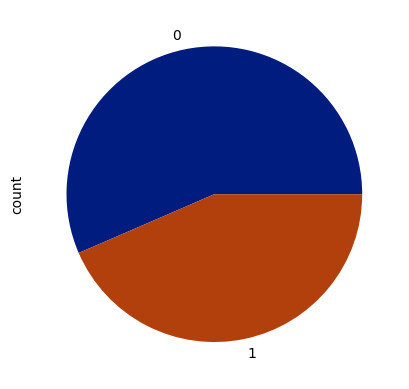

In [24]:
clients_cleaned.gndr.value_counts().plot(kind='pie')
plt.show()

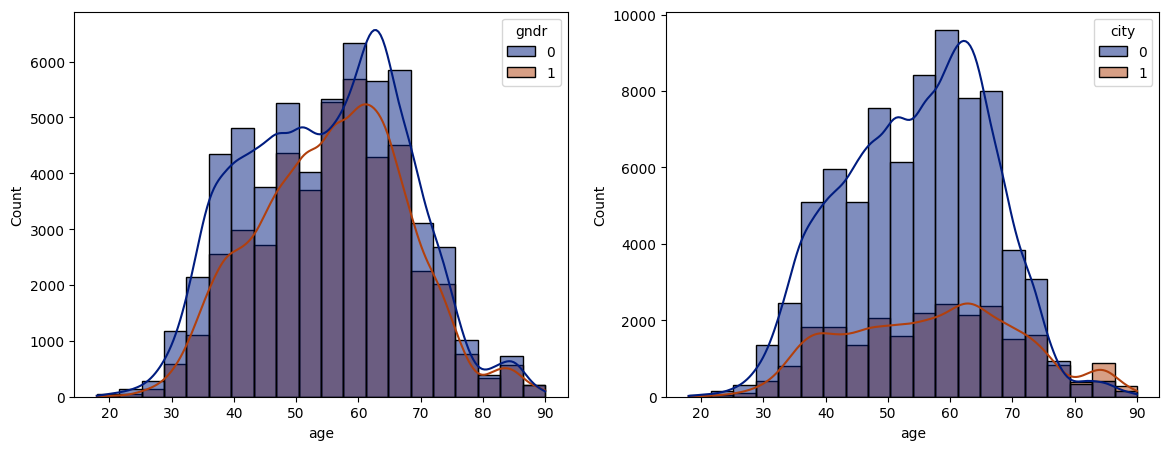

In [25]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(5)
sns.histplot(clients_cleaned, x='age', hue='gndr', bins=20, kde=True, ax=ax[0])
sns.histplot(clients_cleaned, x='age', hue='city', bins=20, kde=True, ax=ax[1])
plt.show()

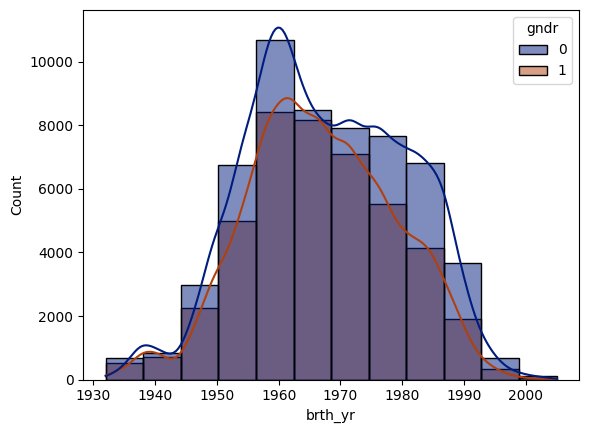

In [26]:
sns.histplot(clients_cleaned, x='brth_yr', hue='gndr', bins=12, kde=True)
plt.show()

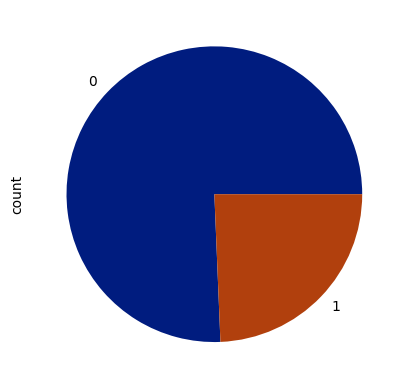

In [27]:
clients_cleaned.city.value_counts().plot(kind='pie')
plt.show()

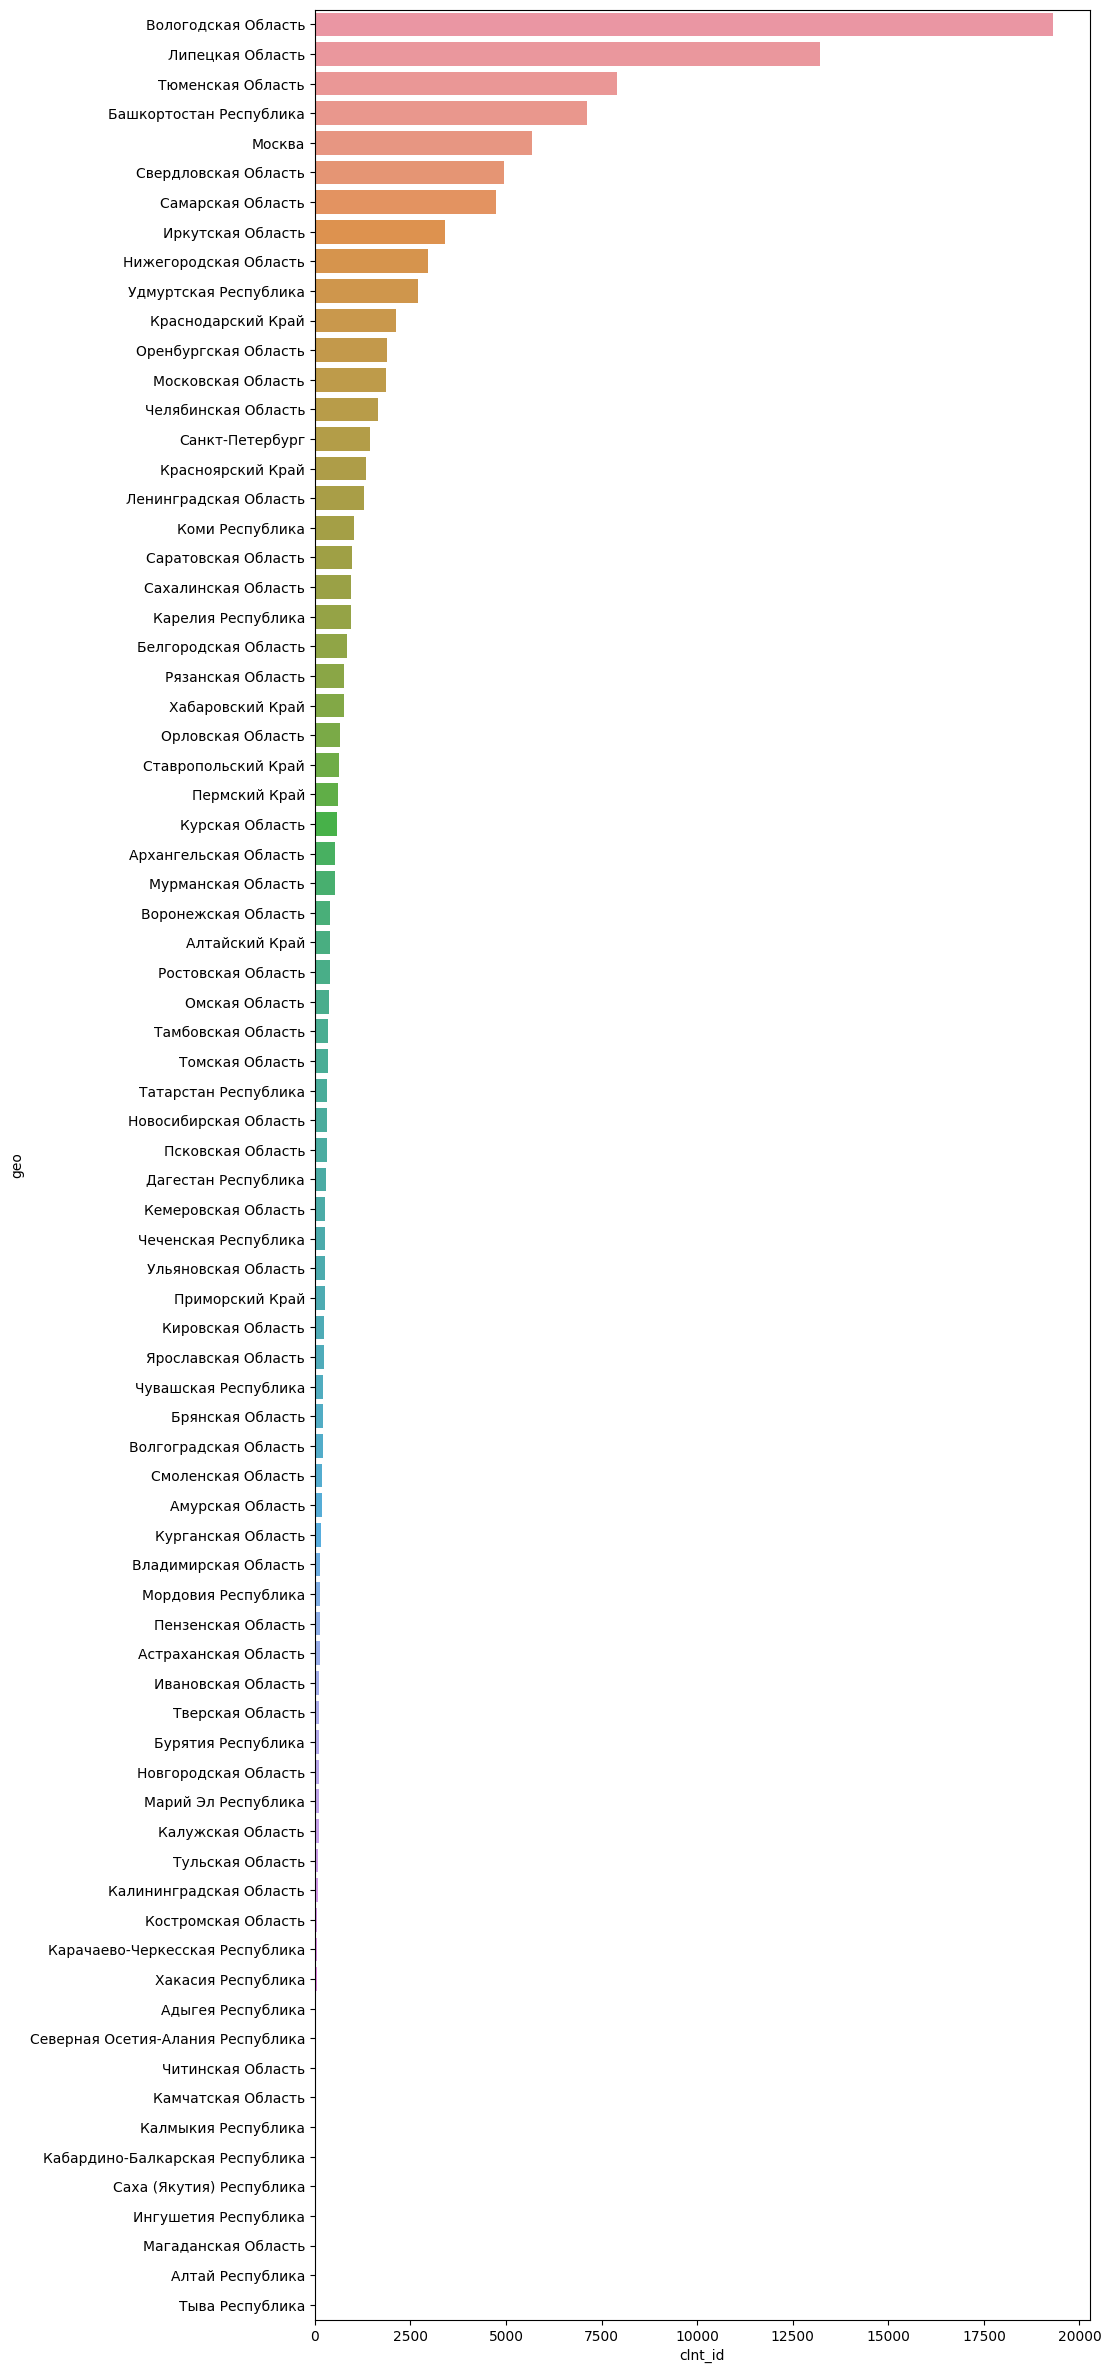

In [28]:
plt.figure(figsize=(10, 30))
sns.barplot(clients_cleaned.groupby('geo', as_index=False).clnt_id.count().sort_values('clnt_id', ascending=False),
            x='clnt_id', y='geo')
plt.show()